In [103]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor


from network import Network
from network import Trainer
from preprocessing import Preprocessing

## Čišćenje dataSet-ova

In [82]:
preprocessing = Preprocessing()

In [4]:
# preprocessing.CheckImages("training/benign/")
# preprocessing.CheckImages("training/malignant/")

# preprocessing.CheckImages("validation/benign/")
# preprocessing.CheckImages("validation/malignant/")

# preprocessing.CheckImages("testing/benign/")
# preprocessing.CheckImages("testing/malignant/")

## Učitavanje podataka u vidu Tensora

In [85]:
trainingData = preprocessing.DataReader("training")
validationData = preprocessing.DataReader("validation")
testingData = preprocessing.DataReader("testing")

In [86]:
trainingIndicies = preprocessing.AppendIndicies(trainingData)
validationIndicies = preprocessing.AppendIndicies(validationData)
testingIndicies = preprocessing.AppendIndicies(testingData)

In [87]:
batchSize = 64

trainingDataLoader = preprocessing.DataLoader(
    trainingIndicies,
    trainingData,
    batchSize = batchSize)

validationDataLoader = preprocessing.DataLoader(
    validationIndicies,
    validationData,
    batchSize = batchSize)

testingDataLoader = preprocessing.DataLoader(
    testingIndicies,
    testingData,
    batchSize = batchSize)

## Prikaz slučajno izabranih snimaka iz sva tri dataSeta 
### Prva vizuelizacija je vizuelizacija dataSeta za trening, zatim slijedi validacioni dataSet i na kraju dataSet za testiranje

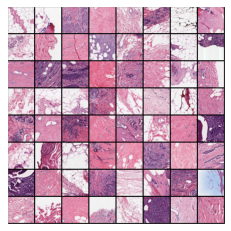

In [7]:
preprocessing.ShowGrid(trainingDataLoader)

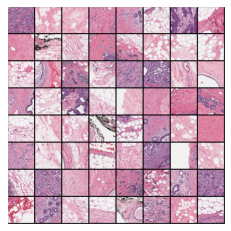

In [8]:
preprocessing.ShowGrid(validationDataLoader)

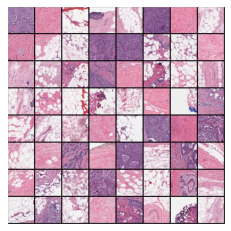

In [9]:
preprocessing.ShowGrid(testingDataLoader)

In [88]:
network = Network()
trainer = Trainer()
# epoch = 0
optimizer = optim.Adam(network.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2)

LOAD_PATH = "../checkpoints/model22.pth"
checkpoint = torch.load(LOAD_PATH)
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']

In [10]:
#epoch = 0
# optimizer = optim.Adam(network.parameters(), lr = 0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2)
epochs = 30

for epoch in range(epoch, epochs):
    
    PATH = f"../checkpoints/model{epoch}.pth"
    trainingLoss, trainingAccuracy = 0, 0 
    valLoss, valCorret = 0, 0
    network.train()
                       
    loop = tqdm(enumerate(trainingDataLoader), total = len(trainingDataLoader), leave = False)
    for batchIndex, (images, labels) in loop:
        
        predictions = network(images)
        loss = F.cross_entropy(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainingLoss += loss.item()
        trainingAccuracy += trainer.Correct(predictions, labels)
        
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(loss = loss.item(), acc = torch.rand(1).item())
    
    array.append([epoch , trainingAccuracy, trainingLoss])
    print(f"Epoch {epoch}\t Total Training Loss: {trainingLoss}\t Total Training Accuracy: {trainingAccuracy}\t Mean Training: {trainingAccuracy / len(trainingData)}")
   
    # Validation     
    valLoss, valCorret = trainer.Validation(network, validationDataLoader, epoch, epochs)
    scheduler.step(valLoss) # optimizing the learning rate
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'scheduler': scheduler.state_dict()
    }, PATH)    
    
    train = open("./data/training.txt", "a")
    for i in trainingArray:
        train.write(i)
    train.close()

  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 23	 Total Training Loss: 215.16017365455627	 Total Training Accuracy: 35269	 Mean Training: 0.8567923428238267


Epoch: 23	 Total Validation Loss: 23.698816373944283	 Total Validation Correct: 3315


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 24	 Total Training Loss: 215.56982749700546	 Total Training Accuracy: 35269	 Mean Training: 0.8567923428238267


Epoch: 24	 Total Validation Loss: 24.971486538648605	 Total Validation Correct: 3203


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 25	 Total Training Loss: 216.1611750125885	 Total Training Accuracy: 35230	 Mean Training: 0.8558449130308036


Epoch: 25	 Total Validation Loss: 24.016030102968216	 Total Validation Correct: 3329


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 26	 Total Training Loss: 214.7733565568924	 Total Training Accuracy: 35295	 Mean Training: 0.857423962685842


Epoch: 26	 Total Validation Loss: 22.802308559417725	 Total Validation Correct: 3306


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 27	 Total Training Loss: 214.98766757547855	 Total Training Accuracy: 35290	 Mean Training: 0.8573024973277621


Epoch: 27	 Total Validation Loss: 24.390560626983643	 Total Validation Correct: 3319


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 28	 Total Training Loss: 212.2305838316679	 Total Training Accuracy: 35375	 Mean Training: 0.85936740841512


Epoch: 28	 Total Validation Loss: 24.751126989722252	 Total Validation Correct: 3220


  0%|          | 0/62 [00:00<?, ?it/s]                                                   

Epoch 29	 Total Training Loss: 212.07174509763718	 Total Training Accuracy: 35373	 Mean Training: 0.859318822271888


Epoch: 29	 Total Validation Loss: 23.25662100315094	 Total Validation Correct: 3322


## Statistika

#### Podaci

In [76]:
avgTrainingLoss = np.array([
        292.175702169537, 264.176949746906, 254.484510391950, 244.992057353258, 247.814041748642, 244.530047357082,
        234.942479237914, 230.273958534002, 230.945887327194, 227.996519088745, 226.583890706300, 225.023277685046,
        228.152878776192, 224.661253720521, 222.871144339442, 222.516436532139, 221.993638046085, 220.709020569920,
        219.983416780829, 219.207040034234, 222.264038264751, 218.974334061145, 218.048034787178, 215.160173654556,
        215.569827497005, 216.161175012588, 214.773356556892, 214.987667575478, 212.230583831667, 212.071745097637])

trainingAcc = np.array([
    32990, 34034, 34253, 34577, 34657, 34538, 34839, 34872, 34867, 34970, 35010, 34983, 34946, 35003, 35089, 35085, 35089,
    35112, 35181, 35169, 35057, 35172, 35161, 35269, 35269, 35230, 35295, 35290, 35375, 35373])

avgValLoss = np.array([
    25.752846837044, 42.166512995958, 25.707503691316, 26.927379041910, 25.309613615274, 25.485200445105, 24.957766756415,
    24.163953050971, 24.717058435082, 26.638843610883, 23.437545254827, 23.503204837441, 24.752062559128, 27.038853332400,
    23.539856433868, 25.796925604343, 22.917965635657, 23.435468897223, 22.551582574844, 24.712370738387, 22.553015097976,
    24.581348896027, 22.600752040744, 23.698816373944, 24.971486538649, 24.016030102968, 22.802308559418, 24.390560626984,
    24.751126989722, 23.256621003151])

valAcc = np.array([
    3279, 3215, 3285, 3267, 3286, 3299, 3281, 3289, 3232, 3310, 3279, 3285, 3307, 3301, 3275, 3292, 3267, 3259, 3297, 3304,
    3305, 3304, 3313, 3315, 3203, 3329, 3306, 3319, 3220, 3322])

In [78]:
trainingLoss = []
for i in avgTrainingLoss:
    trainingLoss.append(i*30)
    
valLoss = []
for j in avgValLoss:
    valLoss.append(j * 30)

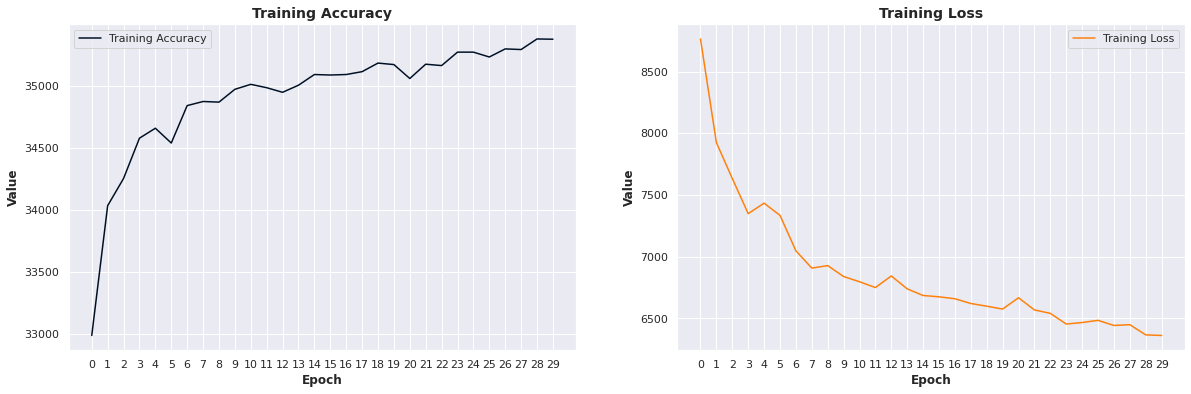

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
ax1.plot(trainingAcc, label = "Training Accuracy", color = "#001024")
ax2.plot(trainingLoss, label = "Training Loss", color = "#FF800B")

ax1.set_title("Training Accuracy", fontsize = 14, fontweight = "bold")
ax2.set_title("Training Loss", fontsize = 14, fontweight = "bold")

ax1.set_xlabel("Epoch", fontsize = 12, fontweight = "bold")
ax1.set_xticks(range(30))
ax1.set_ylabel("Value", fontsize = 12, fontweight = "bold")

ax2.set_xlabel("Epoch", fontsize = 12, fontweight = "bold")
ax2.set_xticks(range(30))
ax2.set_ylabel("Value", fontsize = 12, fontweight = "bold")

sns.set_style("darkgrid")

ax1.legend()
ax2.legend()
plt.show()

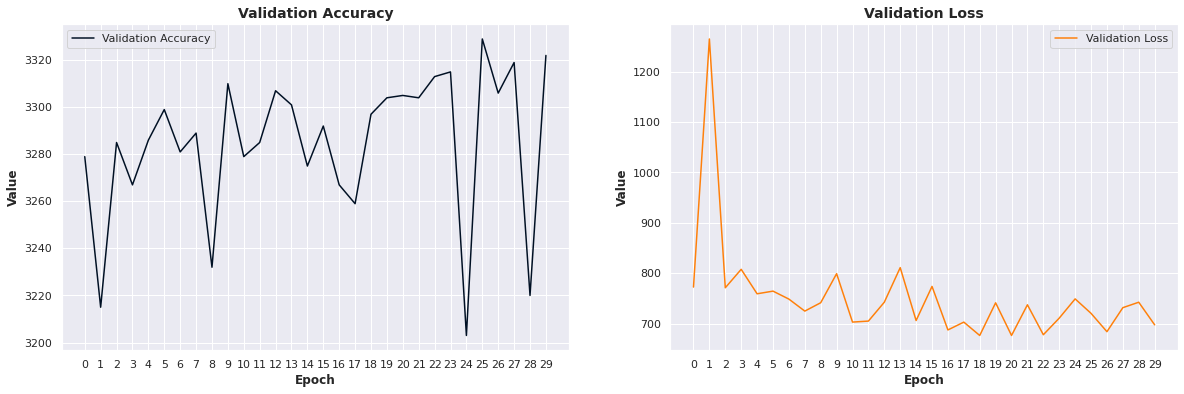

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
ax1.plot(valAcc, label = "Validation Accuracy", color = "#001024")
ax2.plot(valLoss, label = "Validation Loss", color = "#FF800B")

ax1.set_title("Validation Accuracy", fontsize = 14, fontweight = "bold")
ax2.set_title("Validation Loss", fontsize = 14, fontweight = "bold")

ax1.set_xlabel("Epoch", fontsize = 12, fontweight = "bold")
ax1.set_xticks(range(30))
ax1.set_ylabel("Value", fontsize = 12, fontweight = "bold")

ax2.set_xlabel("Epoch", fontsize = 12, fontweight = "bold")
ax2.set_xticks(range(30))
ax2.set_ylabel("Value", fontsize = 12, fontweight = "bold")

plt.ylabel("Value", fontsize = 12, fontweight = "bold")

sns.set_style("darkgrid")

ax1.legend()
ax2.legend()
plt.show()

## Testiranje algoritma

Prema viđenom gubitku najbolji algoritam je u epoch-u 18, zato ćemo njega koristiti za testiranje

In [84]:
network = Network()

PATH = "../checkpoints/model18.pth"
checkpoint = torch.load(PATH)

network.eval()

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1))
  (conv7): Conv2d(192, 384, kernel_size=(5, 5), stride=(1, 1))
  (conv8): Conv2d(384, 768, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3072, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=12, bias=True)
  (fc5): Linear(in_features=12, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=2, bias=True)
)

In [89]:
totalLoss, totalAcc = 0, 0 
for images, targets in testingDataLoader:
    
    predictions = network(images)
    loss = F.cross_entropy(predictions, targets)
    
    totalLoss += loss.item()
    totalAcc += trainer.Correct(predictions, targets)
    

In [112]:
count = len(testingData)
testingAcc = totalAcc / count
wrong = count - totalAcc

print(f"Testing dataset: {count}\t Predicted Correct: {totalAcc}\t Predicted Wrong: {wrong}\t Testing Accuracy (%): {testingAcc * 100}")

Testing dataset: 6229	 Predicted Correct: 5573	 Predicted Wrong: 656	 Testing Accuracy (%): 89.46861454487076
